<a href="https://colab.research.google.com/github/Michael-J1n/coding_challenge/blob/main/Code_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Challenge for VDS Club
Author: Michael Jin

Date: Oct 2024


In [1]:
#@title Import Libraries

!pip install datasets
import re
from datasets import load_dataset

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
#@title Define the Dataset

dataset = load_dataset("yahoo_answers_topics")
# check the shape for the dataset
print(dataset.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.20k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

{'train': (1400000, 5), 'test': (60000, 5)}


In [3]:
# check one data
print(dataset['train'][0])

{'id': 0, 'topic': 4, 'question_title': "why doesn't an optical mouse work on a glass table?", 'question_content': 'or even on some surfaces?', 'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.'}


In [14]:
# split training and testing data
train_data = dataset['train']
test_data = dataset['test']

import random
# define downsample function to random take out 1/100 data points from the original dataset
def downsample(dataset, fraction):
    # calculate the new sample size
    sample_size = int(len(dataset) * fraction)
    # generate random indices for the sample
    random_indices = random.sample(range(len(dataset)), sample_size)
    # select the subset of the dataset
    return dataset.select(random_indices)

# Downsample both train and test datasets to 1/100 of their original size
train_data = downsample(dataset['train'], 1/100)
test_data = downsample(dataset['test'], 1/100)

In [17]:
# check the data after downsampling
print(len(train_data))
print(len(test_data))
print(train_data[0])

14000
600
{'id': 442972, 'topic': 9, 'question_title': 'my license was suspended and i need to drive to work can i get temporary licenses to go to work?', 'question_content': '', 'best_answer': 'have to get it from the court. a work only drivers permit. if cought driving it w/out the permit it  would be a DWLS charge and a visit to the pokey.'}


In [29]:
# check the categories information for original data

import pandas as pd
from collections import Counter

# extract labels
labels = train_data['topic']
# count number of unique labels
category_counts = Counter(labels)
category_counts_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count'])

# print the result
print(f"Number of unique categories: {len(category_counts_df)}")
print("Number of samples in each category:")
print(category_counts_df)

Number of unique categories: 10
Number of samples in each category:
   Category  Count
0         9   1453
1         5   1370
2         2   1458
3         1   1405
4         7   1343
5         4   1409
6         3   1386
7         0   1362
8         6   1381
9         8   1433


In [18]:
#@title Define the Data Cleaning Function

def clean_text(text):
    # convert all words to lower case
    text = text.lower()
    # replace any token that is not a word or a space to empty string
    text = re.sub(r'[^\w\s]', '', text)
    # replace any numbers to empty string
    text = re.sub(r'\d+', '', text)

    words = text.split()
    # remove the stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [19]:
#@title Data Preprocess

# join the question title and question content
train_texts = [f"{sample['question_title']} {sample['question_content']}" for sample in train_data]
# clean the texts
train_texts = [clean_text(text) for text in train_texts]
# extract labels
train_labels = [sample['topic'] for sample in train_data]

# the same process for test data
test_texts = [f"{sample['question_title']} {sample['question_content']}" for sample in test_data]
test_texts = [clean_text(text) for text in test_texts]
test_labels = [sample['topic'] for sample in test_data]

In [20]:
#@title Words Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer
# use TF-IDF to generate vector representation
# max_features: used to restrict on the size of corpus
# keep the words with top 500 highest TF-IDF values
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)  # ngram=(1,3) to extract unigrams, bigrams and trigrams

# convert train and test data to TF-IDF vector
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# define SVM classifier using linear kernel, output is probability
svm_classifier = SVC(kernel='linear', probability=True)
# train KNN classifier, use k=5 and cosine similarity
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='cosine')
# ensemble the two classifiers to vote, and voting use 'soft' which is the probability value
ensemble_classifier = VotingClassifier(estimators=[
    ('svm', svm_classifier), ('knn', knn_classifier)], voting='soft')

# train the classifier to training data
ensemble_classifier.fit(X_train, train_labels)

VotingClassifier(estimators=[('svm', SVC(kernel='linear', probability=True)),
                             ('knn', KNeighborsClassifier(metric='cosine'))],
                 voting='soft')

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# predicted classes
ensemble_predictions = ensemble_classifier.predict(X_test)
# predicted probabilities
ensemble_probabilities = ensemble_classifier.predict_proba(X_test)

# accuracy
accuracy = accuracy_score(test_labels, ensemble_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")
# classification report
print("Classification Report:")
print(classification_report(test_labels, ensemble_predictions))

Accuracy: 55.17%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.39      0.42        54
           1       0.44      0.56      0.49        63
           2       0.60      0.62      0.61        61
           3       0.46      0.50      0.48        62
           4       0.74      0.67      0.70        58
           5       0.65      0.66      0.65        53
           6       0.49      0.48      0.48        65
           7       0.45      0.47      0.46        53
           8       0.62      0.63      0.63        65
           9       0.66      0.53      0.59        66

    accuracy                           0.55       600
   macro avg       0.56      0.55      0.55       600
weighted avg       0.56      0.55      0.55       600



Confusion Matrix:
[[21  1  4  7  1  1  4  6  7  2]
 [ 1 35  3 11  1  4  1  4  1  2]
 [ 1  7 38  1  1  1  5  2  4  1]
 [ 3  9  2 31  2  5  4  2  1  3]
 [ 0  4  4  0 39  1  4  4  2  0]
 [ 1  3  2  2  1 35  0  6  3  0]
 [ 3  7  4  4  4  1 31  4  4  3]
 [ 4  4  2  3  2  3  2 25  2  6]
 [ 7  3  3  2  0  2  5  1 41  1]
 [ 5  6  1  6  2  1  7  2  1 35]]


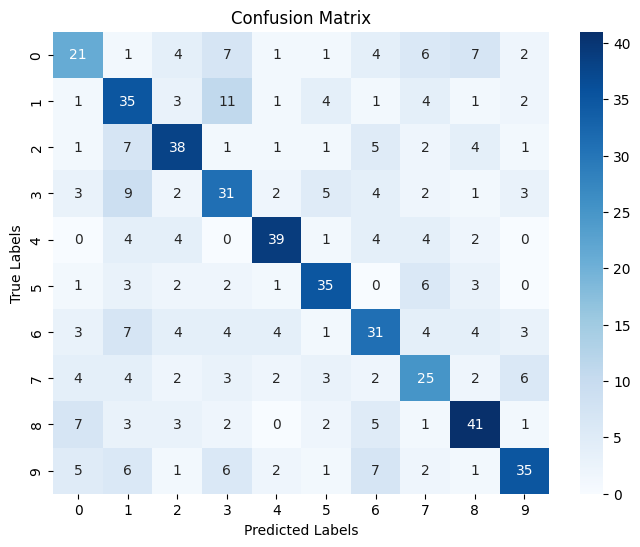

In [25]:
# here, I also use the confusion matrix and its heat map to help visualize the prediction result

# confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(test_labels, ensemble_predictions)
print(cm)

# visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(test_labels), yticklabels=set(test_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# calculate roc-auc score
roc_auc = roc_auc_score(test_labels, ensemble_probabilities, multi_class="ovr")  # use one vs rest strategy calculate roc auc score
print(f"ROC-AUC: {roc_auc:.2f}")

ROC-AUC: 0.87
